In [1]:
import matplotlib
import matplotlib.pyplot as plt
import skimage
import numpy as np
import pandas as pd

In [2]:
from skimage import exposure, io, img_as_float
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.feature_extraction import image
from PIL import Image, ImageEnhance

In [3]:
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from skimage.morphology import label
from skimage.measure import regionprops
from skimage import data, util

In [4]:
import matplotlib.patches as mpatches
from random import random

In [5]:
from scipy import ndimage
from scipy.ndimage import find_objects

In [6]:
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.svm import LinearSVC

In [7]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")
grayscale = rgb2gray(img)

Estimated Gaussian noise standard deviation = 0.12026201002202846


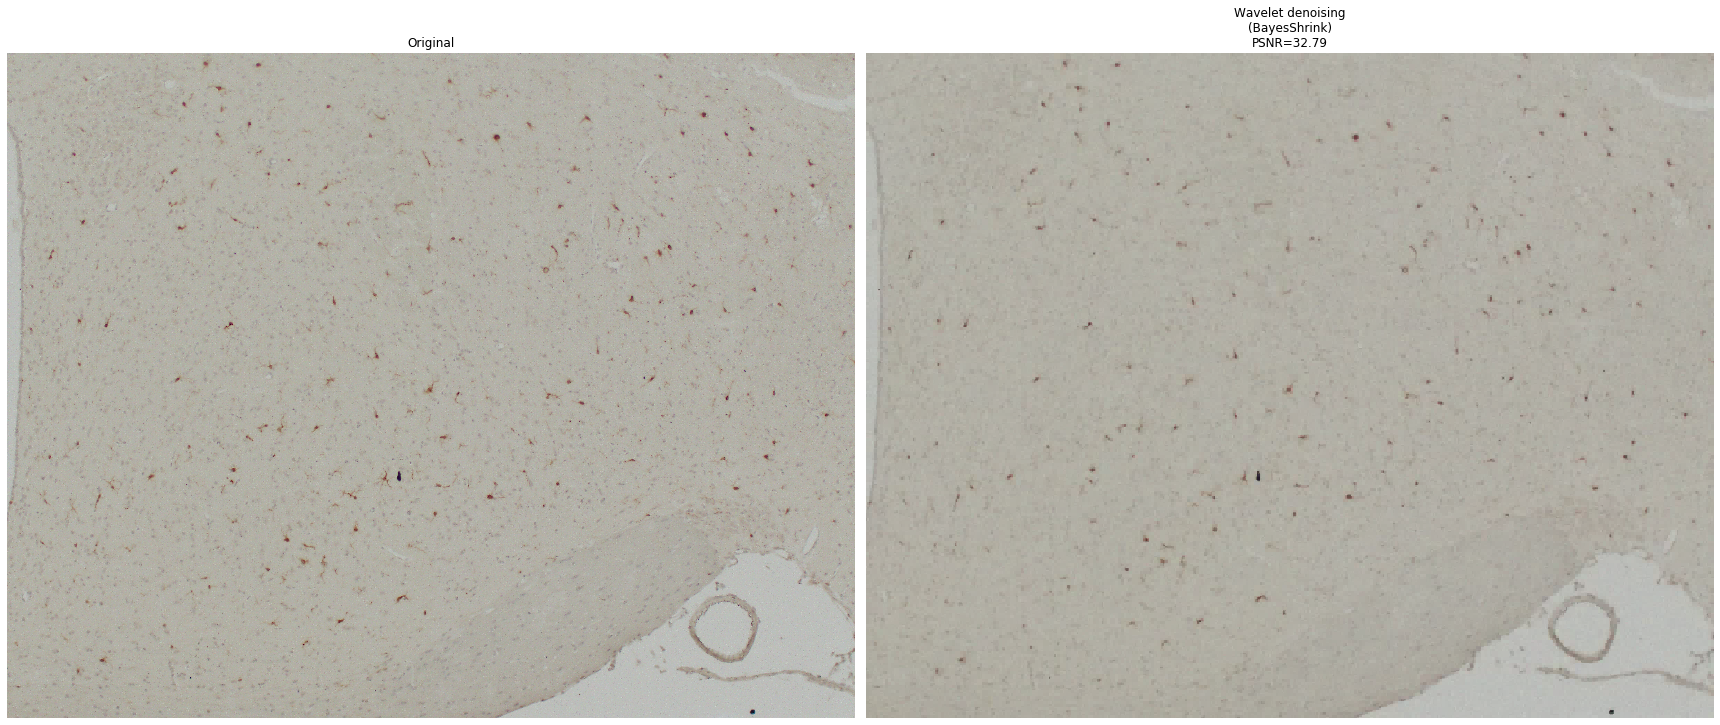

In [8]:
original = img_as_float(img)

sigma = 0.12
noisy = random_noise(original, seed=1, var=sigma**2)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

im_bayes = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True,
                           method='BayesShrink', mode='soft',
                           rescale_sigma=True)

# Compute PSNR as an indication of image quality
psnr_bayes = peak_signal_noise_ratio(original, im_bayes)

ax[1].imshow(im_bayes)
ax[1].axis('off')
ax[1].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[0].imshow(original)
ax[0].axis('off')
ax[0].set_title('Original')
fig.tight_layout()

plt.show()

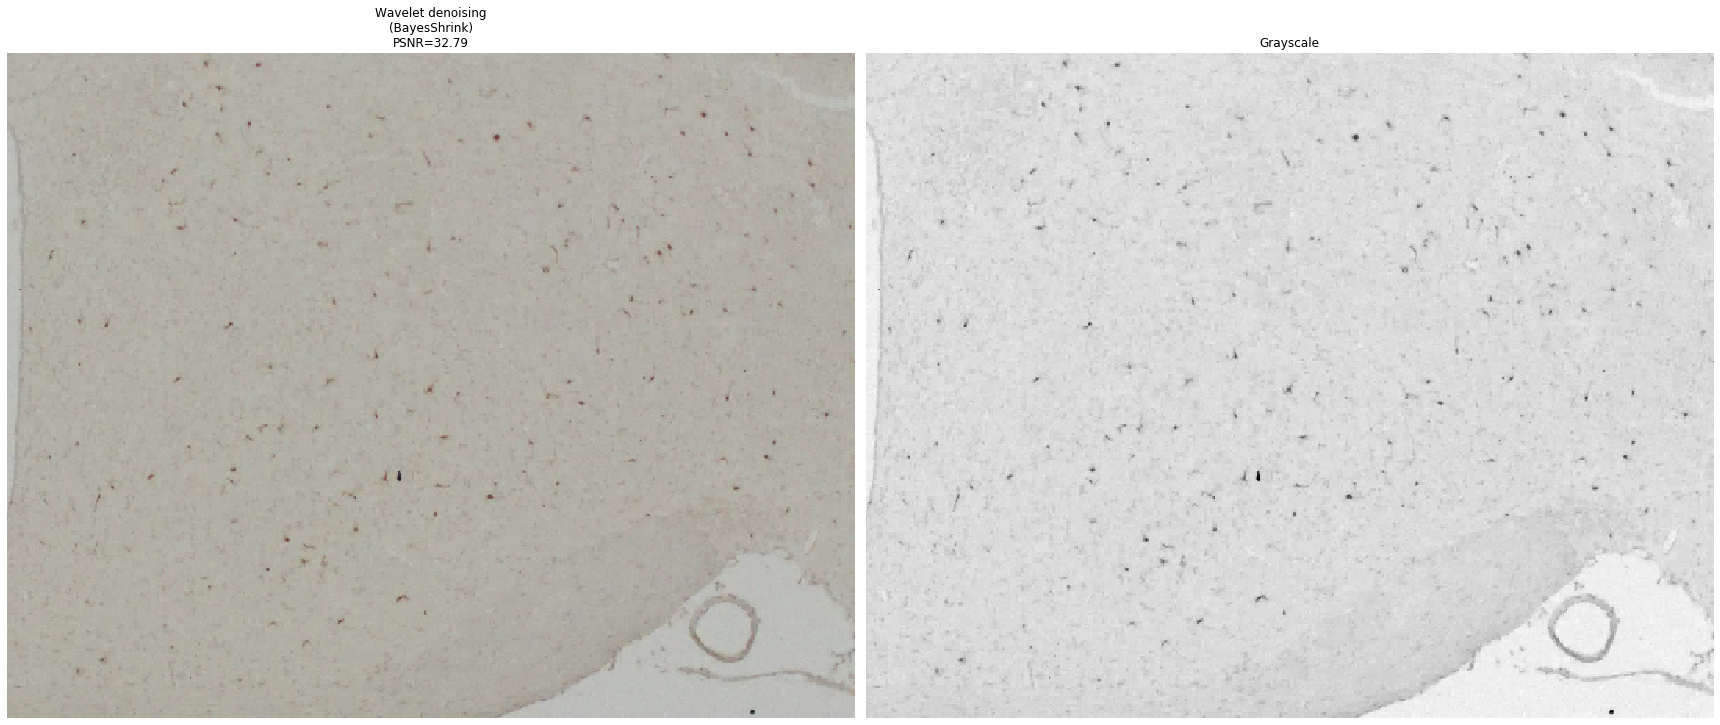

In [9]:
grayscale_bayes = rgb2gray(im_bayes)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(im_bayes)
ax[0].axis('off')
ax[0].set_title(
    'Wavelet denoising\n(BayesShrink)\nPSNR={:0.4g}'.format(psnr_bayes))
ax[1].imshow(grayscale_bayes)
ax[1].axis('off')
ax[1].set_title('Grayscale')
fig.tight_layout()

plt.show()

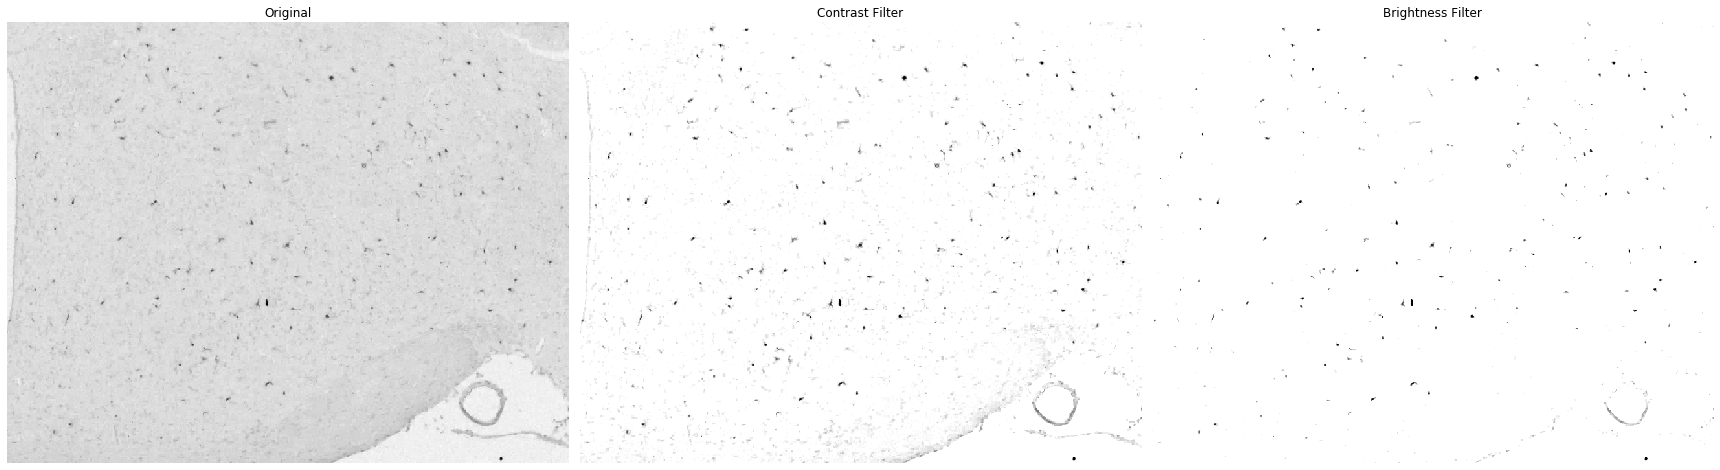

In [10]:
gscale = (grayscale_bayes * 255).astype(np.uint8)
img = Image.fromarray(gscale, mode = 'L')

brightener = ImageEnhance.Brightness(img)
bright_bayes_pil = brightener.enhance(1.5)

contrast = ImageEnhance.Contrast(bright_bayes_pil)
contrast_bayes = contrast.enhance(2)

brightener = ImageEnhance.Brightness(contrast_bayes)
bright_bayes_pil = brightener.enhance(1.2)


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title(
    'Original'.format(psnr_bayes))
ax[2].imshow(bright_bayes_pil)
ax[2].axis('off')
ax[2].set_title('Brightness Filter')
ax[1].imshow(contrast_bayes)
ax[1].axis('off')
ax[1].set_title('Contrast Filter')
fig.tight_layout()

plt.show()

In [11]:
bright_bayes = np.array(bright_bayes_pil)

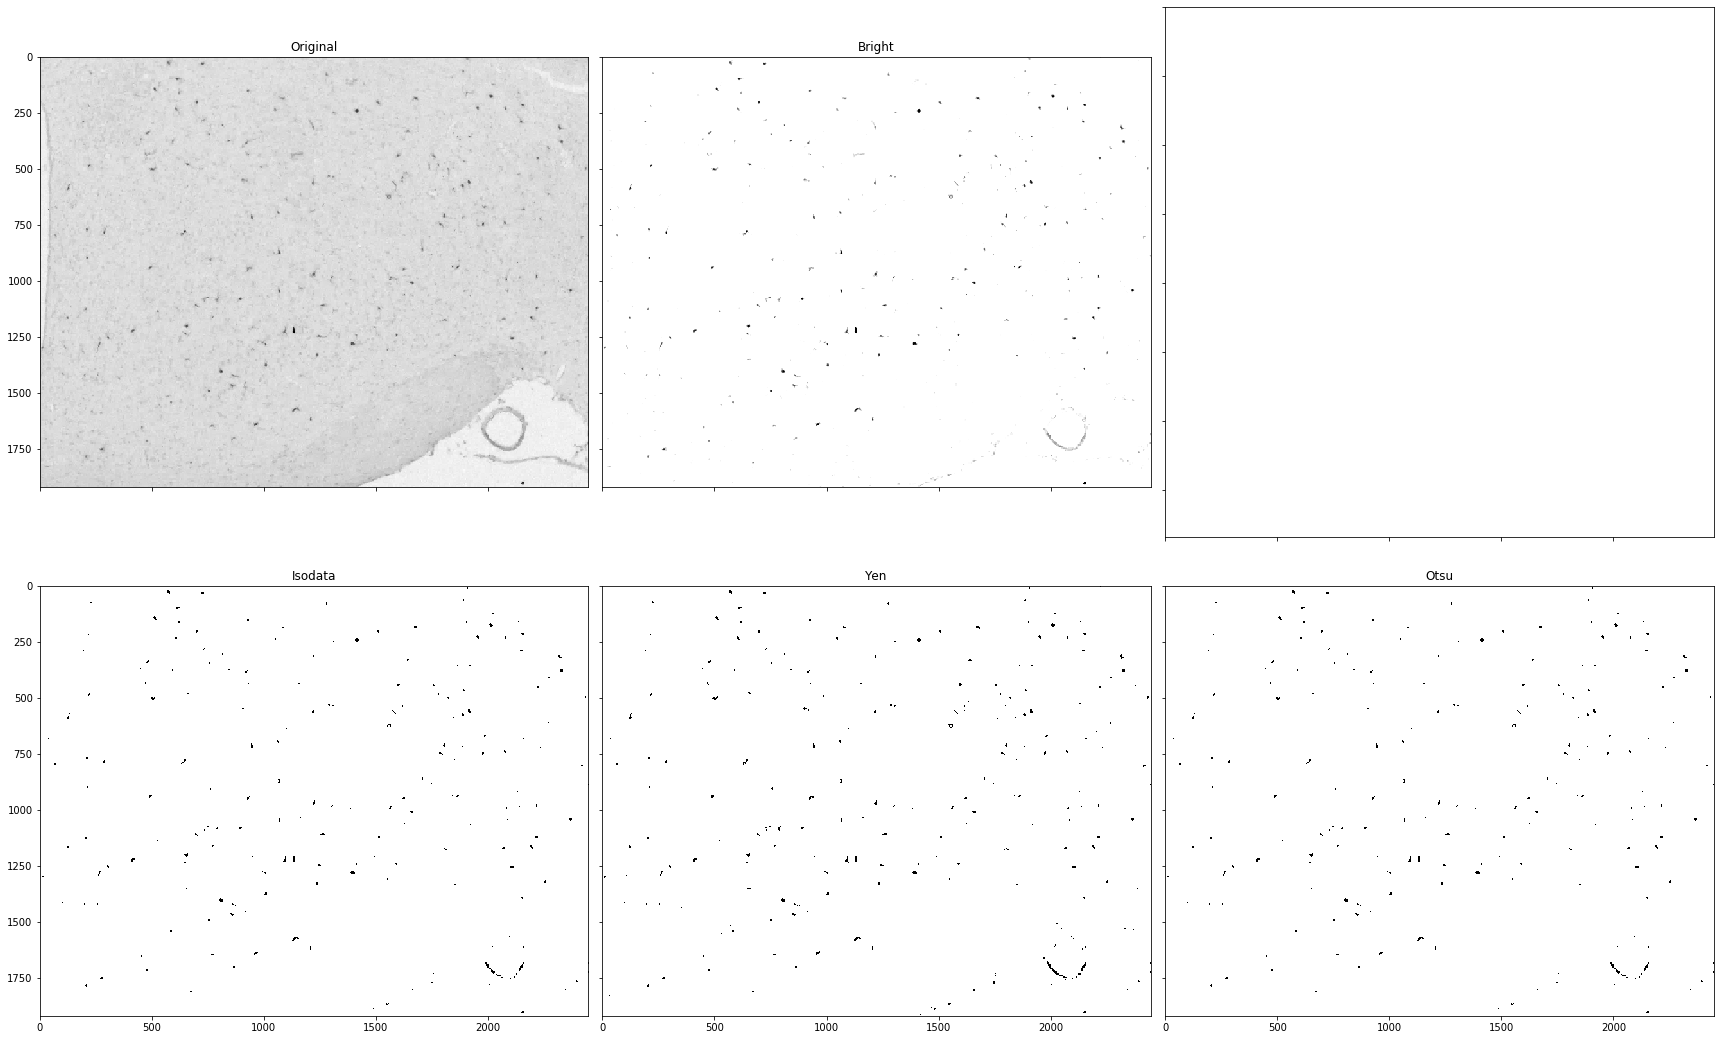

In [12]:
from skimage.filters import threshold_isodata, threshold_yen, threshold_otsu
thresh_iso = threshold_isodata(bright_bayes)
isodata = bright_bayes > thresh_iso

thresh_yen = threshold_yen(bright_bayes)
yen = bright_bayes > thresh_yen

thresh_otsu = threshold_otsu(bright_bayes)
otsu = bright_bayes > thresh_otsu

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 15),
                       sharex=True, sharey=True)

plt.gray()

ax[0, 0].imshow(grayscale_bayes)
ax[0, 0].set_title(
    'Original'.format(psnr_bayes))
ax[0, 1].imshow(bright_bayes)
ax[0, 1].set_title(
    'Bright'.format(psnr_bayes))
ax[1, 0].imshow(isodata)
ax[1, 0].set_title(
    'Isodata'.format(psnr_bayes))
ax[1, 1].imshow(yen)
ax[1, 1].set_title(
    'Yen'.format(psnr_bayes))
ax[1,2].imshow(otsu)
ax[1,2].set_title('Otsu')
fig.tight_layout()

plt.show()

In [13]:
#define new colormap
colors = [(1,1,1)] + [(random(),random(),random()) for i in range(255)]
new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=256)

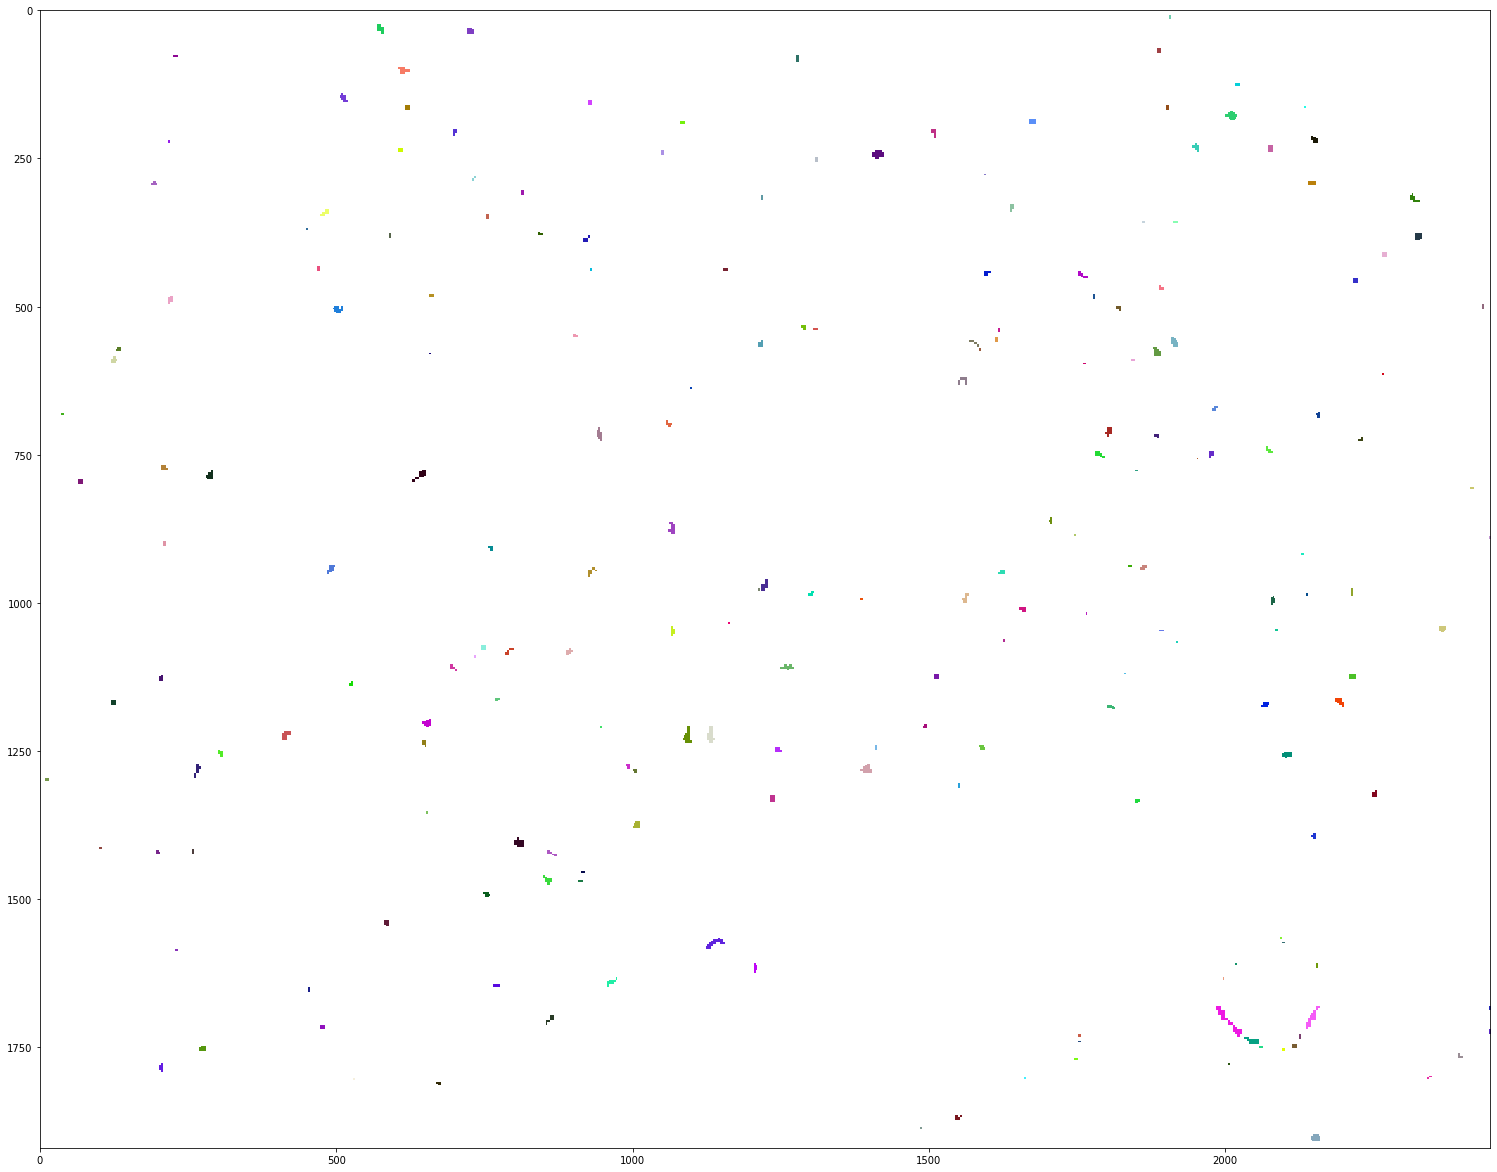

In [14]:
# label image regions
label_image = label(isodata,connectivity=2, background=1)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(26, 26))
ax.imshow(label_image, cmap = new_map)

plt.show()

In [15]:
patches = ndimage.find_objects(label_image)
len(patches)

208

In [16]:
patches_sample = [patches[0], patches[1], patches[2]]
patches_sample

[(slice(8, 16, None), slice(1904, 1908, None)),
 (slice(24, 40, None), slice(568, 580, None)),
 (slice(30, 40, None), slice(720, 732, None))]

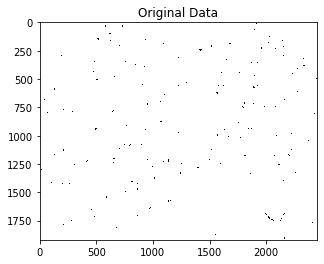

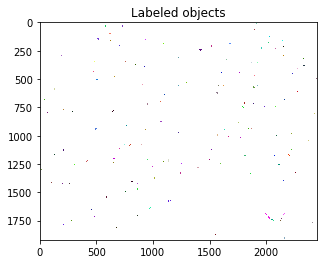

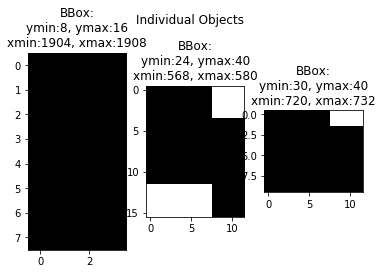

In [17]:
fig, ax = plt.subplots()
ax.imshow(isodata)
ax.set_title('Original Data')

fig, ax = plt.subplots()
ax.imshow(label_image, cmap=new_map)
ax.set_title('Labeled objects')

fig, axes = plt.subplots(ncols=3)
for ax, sli in zip(axes.flat, patches_sample):
    ax.imshow(label_image[sli], cmap = 'gray_r', vmin = 0)
    tpl = 'BBox:\nymin:{0.start}, ymax:{0.stop}\nxmin:{1.start}, xmax:{1.stop}'
    ax.set_title(tpl.format(*sli))
fig.suptitle('Individual Objects')

plt.show()

In [18]:
patch_arrs = []

for i in range(len(patches)):
    patch_arrs.append(np.interp(label_image[patches[i]], 
                                (label_image[patches[i]].min(), label_image[patches[i]].max()), 
                                (0, 1)))

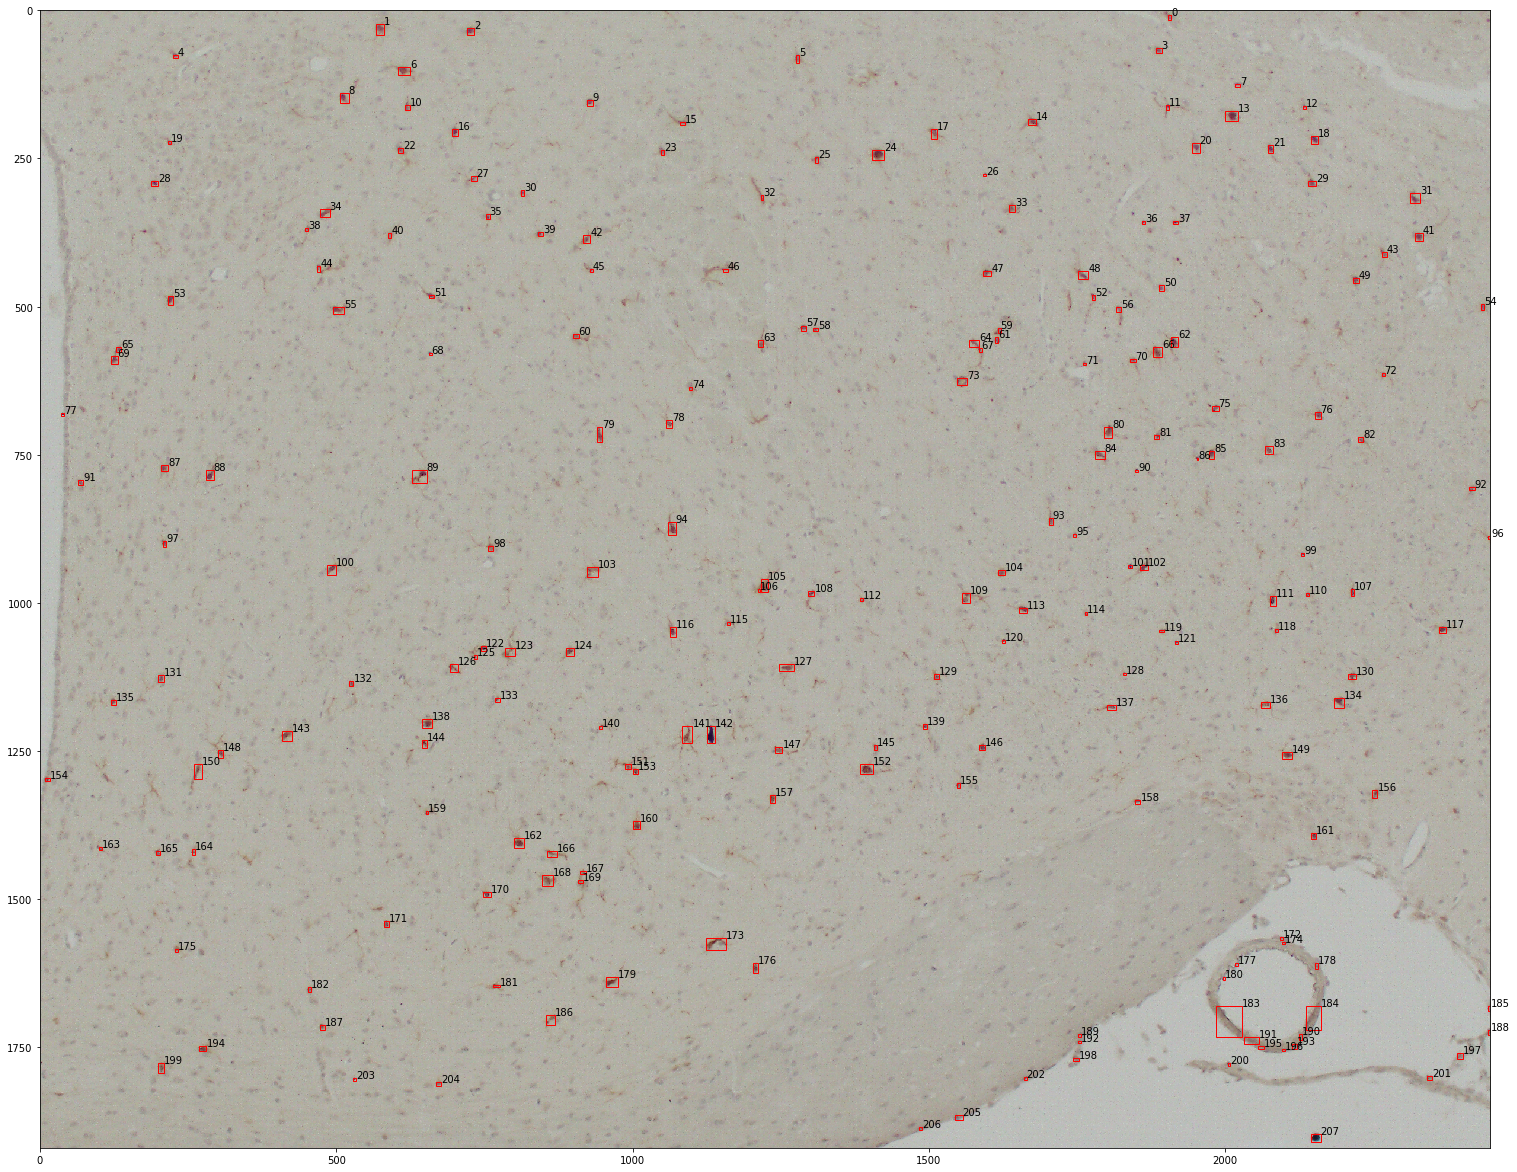

In [19]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

if __name__ == '__main__':
    fig = plt.figure(figsize=(26, 26))
    ax = fig.add_subplot(111)

    data = original
    im = ax.imshow(data)    
    data_slices = patches

    bboxes = slice_to_bbox(data_slices)
    i=0
    for bbox in bboxes:
        xwidth = bbox.x2 - bbox.x1
        ywidth = bbox.y2 - bbox.y1
        p = mpatches.Rectangle((bbox.x1, bbox.y1), xwidth, ywidth,
                              fc = 'none', ec = 'red')
        ax.add_patch(p)
        ax.text(bbox.x2, bbox.y1, str(i))
        i+=1

    plt.show()

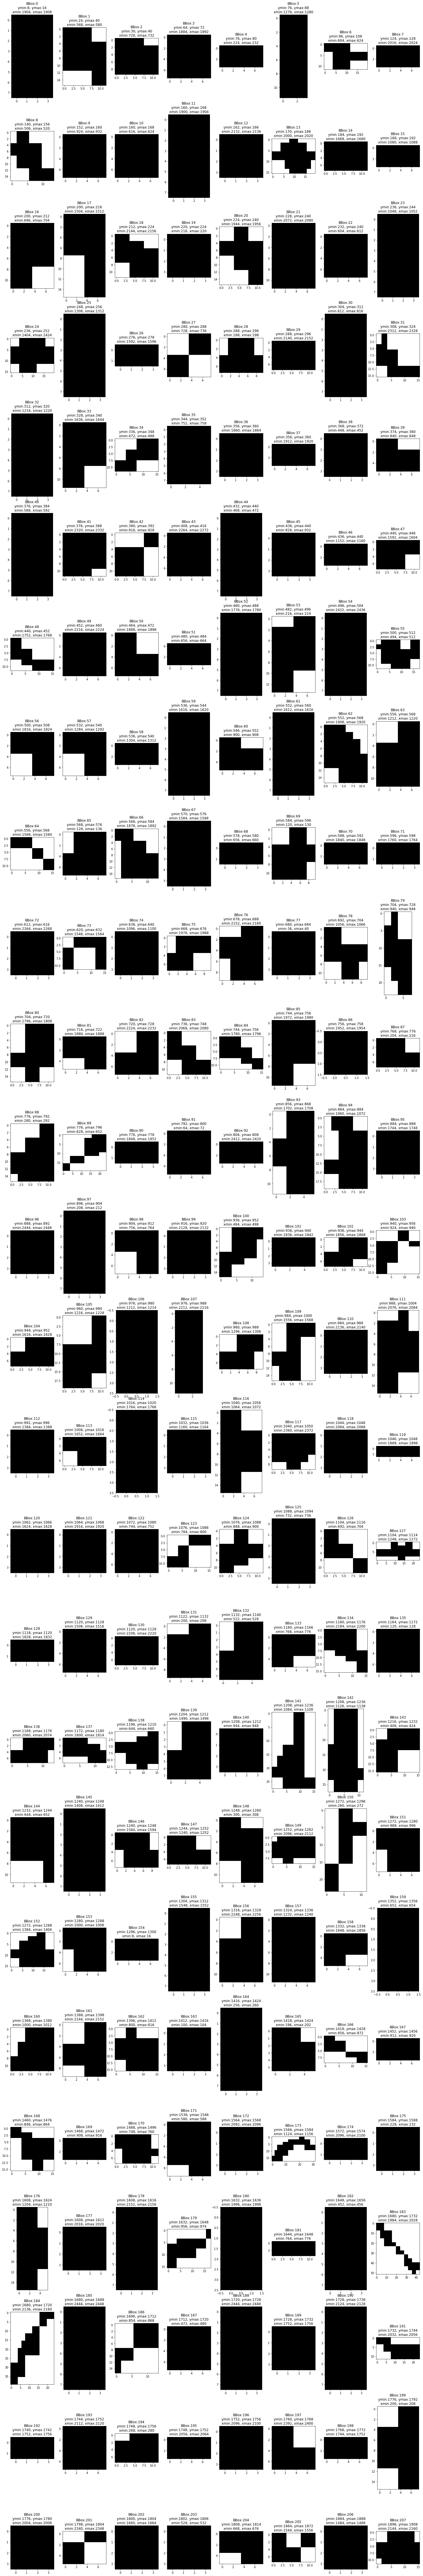

In [20]:
fig, axes = plt.subplots(ncols=8, nrows=26, figsize=(26, 168))
i=0
for ax, sli in zip(axes.flat, patches):
    ax.imshow(label_image[sli], cmap = 'gray_r', vmin = 0)
    tpl = 'BBox:' +str(i) +'\nymin:{0.start}, ymax:{0.stop}\nxmin:{1.start}, xmax:{1.stop}'
    ax.set_title(tpl.format(*sli))
    i+=1

plt.show()

In [21]:
labels = np.ones(len(patches)).astype(int)

In [22]:
zeros = [7, 11, 12, 15, 19, 25, 26, 27, 32, 36, 37, 38, 40, 44, 45, 46, 54, 64, 67, 68, 71, 72, 73, 
         77, 86, 90, 91, 92, 95, 96, 99, 101, 106, 110, 112, 114, 115, 118, 119, 120, 121, 125, 
         128, 133, 136, 137, 139, 140, 142, 154, 155, 159, 166, 169, 175, 182, 187, 203, 204, 
         172, 174, 177, 178, 180, 183, 184, 185, 188, 189, 190, 191, 192, 193, 195, 196, 197, 198, 200, 201, 202, 205, 206, 207]

#23, 33, 51, 52, 60, 74, 78, 97, 145, 161, 163, 164, 165, 167, 181
#27, 36, 37, 44, 45, 64, 72, 133, 136, 137, 139, 155, 182, 187
for neg in zeros:
    labels[neg] = 0
    
labels

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
df = pd.DataFrame(columns=['solidity', 'orientation', 'diameter', 'area', 'eccentricity', 'convex area', 'major axis length', 
                 'minor axis length', 'extent'])

In [24]:
regions = regionprops(label_image)

for region in regions:
    region_dict = {'solidity': region.solidity,
                   'orientation': region.orientation,
                   'diameter': region.equivalent_diameter,
                   'area': region.area,
                   'eccentricity': region.eccentricity,
                   'convex area': region.convex_area,
                   'major axis length': region.major_axis_length,
                   'minor axis length': region.minor_axis_length,
                   'extent': region.extent}
    df=df.append(region_dict, ignore_index=True)
    
df.head()

solidity  orientation   diameter   area  eccentricity  convex area  \
0  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1  0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2  0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3  1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4  1.000000     1.570796   6.383076   32.0      0.872872         32.0   

   major axis length  minor axis length    extent  
0           9.165151           4.472136  1.000000  
1          17.580112          11.364941  0.750000  
2          13.746256          10.763679  0.933333  
3           9.165151           9.165151  1.000000  
4           9.165151           4.472136  1.000000

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


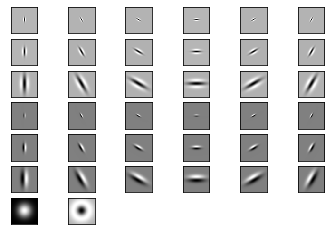

In [25]:
#https://gist.github.com/amueller/3129692
##########################################################################
# Maximum Response filterbank from
# http://www.robots.ox.ac.uk/~vgg/research/texclass/filters.html
# based on several edge and bar filters.
# Adapted to Python by Andreas Mueller amueller@ais.uni-bonn.de
# Share and enjoy
#

import cv2
import pickle

from itertools import product, chain

def makeRFSfilters(radius=28, sigmas=[1, 2, 4], n_orientations=6):
    """ Generates filters for RFS filterbank.
    Parameters
    ----------
    radius : int, default 28
        radius of all filters. Size will be 2 * radius + 1
    sigmas : list of floats, default [1, 2, 4]
        define scales on which the filters will be computed
    n_orientations : int
        number of fractions the half-angle will be divided in
    Returns
    -------
    edge : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains edge filters on different scales and orientations
    bar : ndarray (len(sigmas), n_orientations, 2*radius+1, 2*radius+1)
        Contains bar filters on different scales and orientations
    rot : ndarray (2, 2*radius+1, 2*radius+1)
        contains two rotation invariant filters, Gaussian and Laplacian of
        Gaussian
    """
    def make_gaussian_filter(x, sigma, order=0):
        if order > 2:
            raise ValueError("Only orders up to 2 are supported")
        # compute unnormalized Gaussian response
        response = np.exp(-x ** 2 / (2. * sigma ** 2))
        if order == 1:
            response = -response * x
        elif order == 2:
            response = response * (x ** 2 - sigma ** 2)
        # normalize
        response /= np.abs(response).sum()
        return response

    def makefilter(scale, phasey, pts, sup):
        gx = make_gaussian_filter(pts[0, :], sigma=3 * scale)
        gy = make_gaussian_filter(pts[1, :], sigma=scale, order=phasey)
        temp = gx*gy
        temp = np.reshape(temp,(gx.shape[0],1))
        #f = (gx * gy).reshape(sup, sup)
        f = np.reshape(temp,(int(sup), int(sup)))
        # normalize
        f /= np.abs(f).sum()
        return f

    support = 2 * radius + 1
    x, y = np.mgrid[-radius:radius + 1, radius:-radius - 1:-1]
    orgpts = np.vstack([x.ravel(), y.ravel()])

    rot, edge, bar = [], [], []
    for sigma in sigmas:
        for orient in range(n_orientations):
            # Not 2pi as filters have symmetry
            angle = np.pi * orient / n_orientations
            c, s = np.cos(angle), np.sin(angle)
            rotpts = np.dot(np.array([[c, -s], [s, c]]), orgpts)
            edge.append(makefilter(sigma, 1, rotpts, support))
            bar.append(makefilter(sigma, 2, rotpts, support))

    print (len(rot), len(bar))
    length = np.sqrt(x ** 2 + y ** 2)
    rot.append(make_gaussian_filter(length, sigma=10))
    rot.append(make_gaussian_filter(length, sigma=10, order=2))

    # reshape rot and edge
    edge = np.asarray(edge)
    edge = edge.reshape(len(sigmas), n_orientations, int(support), int(support))
    bar = np.asarray(bar).reshape(edge.shape)
    rot = np.asarray(rot)[:, np.newaxis, :, :]
    print (edge.shape, bar.shape, rot.shape)
    return edge, bar, rot


def apply_filterbank(img, filterbank):
    from scipy.ndimage import convolve
    result = []
    for battery in filterbank:
        for scale in battery:
            response = []
            for filt in scale:
                response.append(convolve(img, filt))
            max_response = np.max(response, axis=0)
            result.append(max_response)
    return result


if __name__ == "__main__":

    sigmas = [1, 2, 4]
    n_sigmas = len(sigmas)
    n_orientations = 6

    edge, bar, rot = makeRFSfilters(sigmas=sigmas,
            n_orientations=n_orientations)

    n = n_sigmas * n_orientations

    # plot filters
    # 2 is for bar / edge, + 1 for rot
    fig, ax = plt.subplots(n_sigmas * 2 + 1, n_orientations)
    for k, filters in enumerate([bar, edge]):
        for i, j in product(range(n_sigmas), range(n_orientations)):
            row = i + k * n_sigmas
            ax[row, j].imshow(filters[i, j, :, :], cmap=plt.cm.gray)
            ax[row, j].set_xticks(())
            ax[row, j].set_yticks(())
    ax[-1, 0].imshow(rot[0, 0], cmap=plt.cm.gray)
    ax[-1, 0].set_xticks(())
    ax[-1, 0].set_yticks(())
    ax[-1, 1].imshow(rot[1, 0], cmap=plt.cm.gray)
    ax[-1, 1].set_xticks(())
    ax[-1, 1].set_yticks(())
    for i in range(2, n_orientations):
        ax[-1, i].set_visible(False)

    plt.show()

In [26]:
filterbank = makeRFSfilters()
top8_arr = []

for patch in patch_arrs:
    top8_arr.append(apply_filterbank(patch, filterbank))

0 18
(3, 6, 57, 57) (3, 6, 57, 57) (2, 1, 57, 57)


In [27]:
df_text = pd.DataFrame(columns=['edge1', 'edge2', 'edge3', 'bar1', 'bar2', 'bar3', 'gauss', 'lap'])

In [28]:
for top8 in top8_arr:
    top8_dict = {'edge1': np.max(top8[0]),
                 'edge2': np.max(top8[1]),
                 'edge3': np.max(top8[2]),
                 'bar1': np.max(top8[3]),
                 'bar2': np.max(top8[4]),
                 'bar3': np.max(top8[5]),
                 'gauss': np.max(top8[6]),
                 'lap': np.max(top8[7])}
    df_text=df_text.append(top8_dict, ignore_index=True)
df_text.head()

edge1         edge2         edge3          bar1          bar2  \
0  4.258764e-08  5.366573e-04  2.608983e-03  4.477110e-10  6.871495e-04   
1  4.067594e-01  2.482726e-01  1.655821e-01  2.479452e-01  2.272669e-01   
2  4.067510e-01  2.281953e-01  9.565853e-02  2.416125e-01  2.474537e-01   
3  9.471111e-18  5.210919e-17  8.046007e-18 -3.461109e-15 -9.540562e-15   
4  2.476576e-09  5.613179e-04  6.251779e-03 -3.502866e-15 -9.100045e-15   

           bar3     gauss       lap  
0  3.629560e-03  0.999050  0.679266  
1  3.267934e-01  0.774235  0.587864  
2  1.242316e-01  0.938396  0.654844  
3 -4.974419e-11  1.000000  0.682094  
4 -4.882439e-11  0.992363  0.659058

In [29]:
df = df.join(df_text)
df.head()

solidity  orientation   diameter   area  eccentricity  convex area  \
0  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1  0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2  0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3  1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4  1.000000     1.570796   6.383076   32.0      0.872872         32.0   

   major axis length  minor axis length    extent         edge1         edge2  \
0           9.165151           4.472136  1.000000  4.258764e-08  5.366573e-04   
1          17.580112          11.364941  0.750000  4.067594e-01  2.482726e-01   
2          13.746256          10.763679  0.933333  4.067510e-01  2.281953e-01   
3           9.165151           9.165151  1.000000  9.471111e-18  5.210919e-17   
4           9.165151           4.472136  1.000000  2.476576e-09  5.613179e-04   

          edge3          bar1          bar2          bar3     gauss       lap  
0  2.608983e-03  4.477110e-10  6.871495e-04  3.629560e-03  0.999050  0.679266  
1  1.655821e-01  2.479452e-01  2.272669e-01  3.267934e-01  0.774235  0.587864  
2  9.565853e-02  2.416125e-01  2.474537e-01  1.242316e-01  0.938396  0.654844  
3  8.046007e-18 -3.461109e-15 -9.540562e-15 -4.974419e-11  1.000000  0.682094  
4  6.251779e-03 -3.502866e-15 -9.100045e-15 -4.882439e-11  0.992363  0.659058

In [30]:
hog_arr = []

for patch in patch_arrs:
    if (patch.shape >= (4,4)):
        hogpatch = hog(patch, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
        hog_arr.append(np.max(hogpatch))
    else:
        hog_arr.append(0.)

df['hog'] = hog_arr
df.head()

solidity  orientation   diameter   area  eccentricity  convex area  \
0  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1  0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2  0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3  1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4  1.000000     1.570796   6.383076   32.0      0.872872         32.0   

   major axis length  minor axis length    extent         edge1         edge2  \
0           9.165151           4.472136  1.000000  4.258764e-08  5.366573e-04   
1          17.580112          11.364941  0.750000  4.067594e-01  2.482726e-01   
2          13.746256          10.763679  0.933333  4.067510e-01  2.281953e-01   
3           9.165151           9.165151  1.000000  9.471111e-18  5.210919e-17   
4           9.165151           4.472136  1.000000  2.476576e-09  5.613179e-04   

          edge3          bar1          bar2          bar3     gauss       lap  \
0  2.608983e-03  4.477110e-10  6.871495e-04  3.629560e-03  0.999050  0.679266   
1  1.655821e-01  2.479452e-01  2.272669e-01  3.267934e-01  0.774235  0.587864   
2  9.565853e-02  2.416125e-01  2.474537e-01  1.242316e-01  0.938396  0.654844   
3  8.046007e-18 -3.461109e-15 -9.540562e-15 -4.974419e-11  1.000000  0.682094   
4  6.251779e-03 -3.502866e-15 -9.100045e-15 -4.882439e-11  0.992363  0.659058   

   hog  
0  0.0  
1  1.0  
2  1.0  
3  0.0  
4  0.0

In [31]:
df['label'] = labels
df.head()

solidity  orientation   diameter   area  eccentricity  convex area  \
0  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1  0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2  0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3  1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4  1.000000     1.570796   6.383076   32.0      0.872872         32.0   

   major axis length  minor axis length    extent         edge1         edge2  \
0           9.165151           4.472136  1.000000  4.258764e-08  5.366573e-04   
1          17.580112          11.364941  0.750000  4.067594e-01  2.482726e-01   
2          13.746256          10.763679  0.933333  4.067510e-01  2.281953e-01   
3           9.165151           9.165151  1.000000  9.471111e-18  5.210919e-17   
4           9.165151           4.472136  1.000000  2.476576e-09  5.613179e-04   

          edge3          bar1          bar2          bar3     gauss       lap  \
0  2.608983e-03  4.477110e-10  6.871495e-04  3.629560e-03  0.999050  0.679266   
1  1.655821e-01  2.479452e-01  2.272669e-01  3.267934e-01  0.774235  0.587864   
2  9.565853e-02  2.416125e-01  2.474537e-01  1.242316e-01  0.938396  0.654844   
3  8.046007e-18 -3.461109e-15 -9.540562e-15 -4.974419e-11  1.000000  0.682094   
4  6.251779e-03 -3.502866e-15 -9.100045e-15 -4.882439e-11  0.992363  0.659058   

   hog  label  
0  0.0      1  
1  1.0      1  
2  1.0      1  
3  0.0      1  
4  0.0      1

In [32]:
df = df.replace([np.inf], sys.float_info.max)
df.fillna(method ='ffill', inplace = True)

In [33]:
columns_to_scale = ['edge1', 'edge2', 'edge3', 'bar1', 'bar2', 'bar3', 'gauss', 'lap', 'hog']
scaler = MinMaxScaler(feature_range=(0, 1))
for column in columns_to_scale:
    df[column] = scaler.fit_transform(df[column].values.reshape(-1, 1))
df.head()

/Users/amy/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/amy/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/amy/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/amy/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


solidity  orientation   diameter   area  eccentricity  convex area  \
0  1.000000     0.000000   6.383076   32.0      0.872872         32.0   
1  0.888889     0.624523  13.540550  144.0      0.762943        162.0   
2  0.965517     1.287946  11.941643  112.0      0.621989        116.0   
3  1.000000     0.785398   9.027033   64.0      0.000000         64.0   
4  1.000000     1.570796   6.383076   32.0      0.872872         32.0   

   major axis length  minor axis length    extent          edge1  \
0           9.165151           4.472136  1.000000  2.369016e-316   
1          17.580112          11.364941  0.750000  2.262674e-309   
2          13.746256          10.763679  0.933333  2.262628e-309   
3           9.165151           9.165151  1.000000   0.000000e+00   
4           9.165151           4.472136  1.000000  1.377641e-317   

           edge2          edge3           bar1           bar2           bar3  \
0  2.985255e-312  1.451295e-311  1.469498e-315  1.686636e-241  1.460139e-242   
1  1.381062e-309  9.210811e-310  1.379242e-309  5.578359e-239  3.381257e-241   
2  1.269379e-309  5.321182e-310  1.344016e-309  6.073852e-239  1.353380e-241   
3   0.000000e+00   0.000000e+00  1.467008e-315   0.000000e+00  1.096778e-242   
4  3.122435e-312  3.477667e-311  1.467008e-315  1.081269e-253  1.096778e-242   

           gauss            lap  hog  label  
0  3.659957e-309  2.294967e-309  0.0      1  
1  2.409382e-309  1.786530e-309  1.0      1  
2  3.322555e-309  2.159116e-309  1.0      1  
3  3.665240e-309  2.310700e-309  0.0      1  
4  3.622758e-309  2.182556e-309  0.0      1

In [34]:
# train-test split
df_X = df.iloc[:, 0:18]
df_Y = df.iloc[:, 18]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2)

X_train, X_test, y_train, y_test = X_train.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_test.to_numpy()

In [46]:
y_test

array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1])

Nearest Neighbors : 0.7857142857142857 recall: 0.9473684210526315 precision: 0.6923076923076923 F1: 0.7999999999999999
[ 2  5  9 12 13 19 20 28 29]


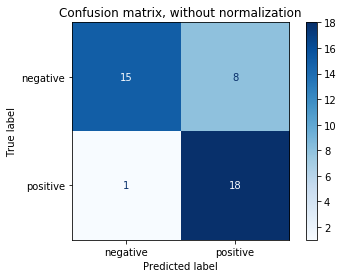

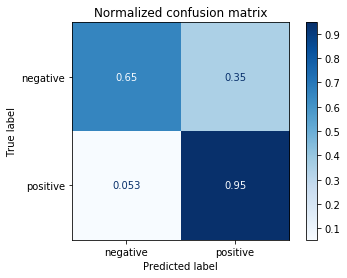

Linear SVM : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


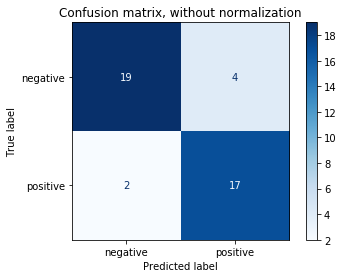

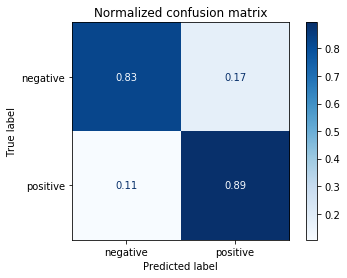

RBF SVM : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


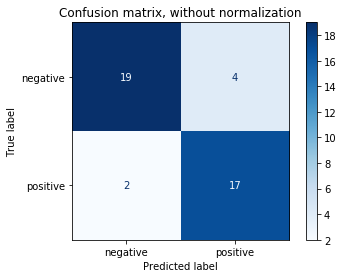

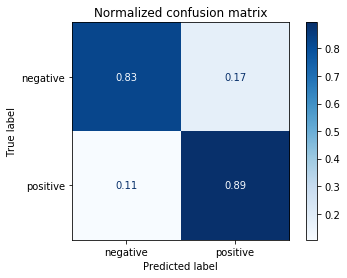

Gaussian Process : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


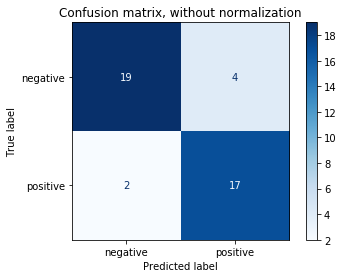

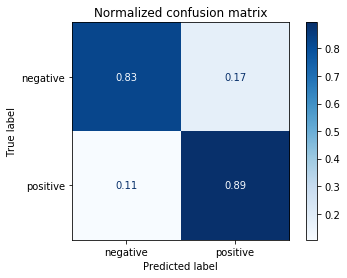

Decision Tree : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


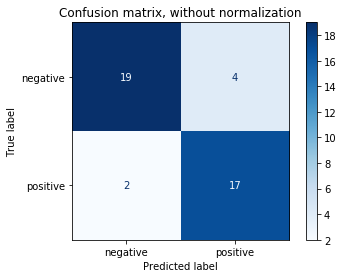

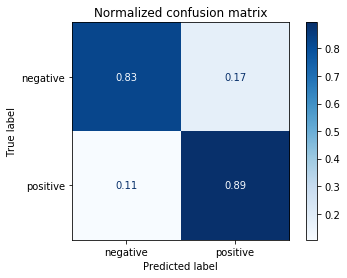

Random Forest : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


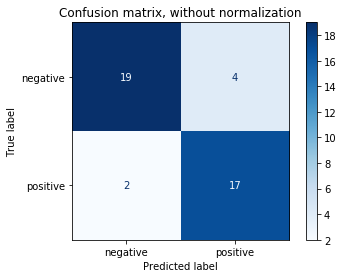

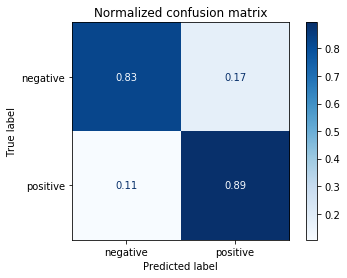

/Users/amy/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


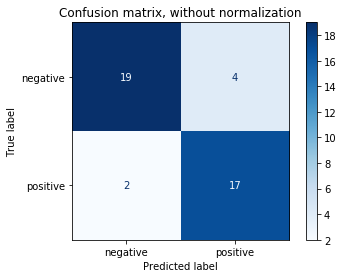

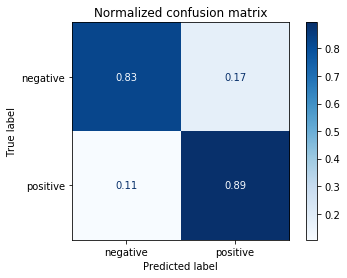

AdaBoost : 0.8571428571428571 recall: 0.8947368421052632 precision: 0.8095238095238095 F1: 0.8500000000000001
[ 9 13 20 29 30 41]


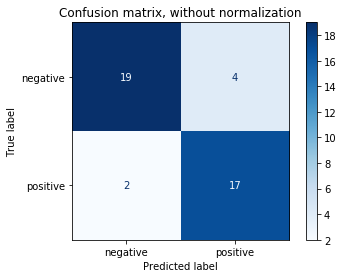

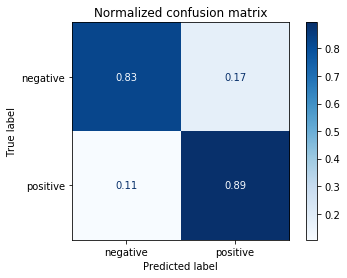

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, f1_score

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.1),
    SVC(),
    GaussianProcessClassifier(1.0 * RBF(2.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=20),
    MLPClassifier(max_iter=800),
    AdaBoostClassifier(n_estimators=10)]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(name,':', score, 'recall:', recall, 'precision:', precision, 'F1:',f1)
    print(np.flatnonzero(y_test != y_pred))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['negative', 'positive'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()

In [37]:
#this classifier is going to give a prediction for each patch, 
#so to get the total number of positive cells in an image we will need to sum the label values of the patches